In [3]:
# Importing libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from google.colab import drive

In [4]:
# Mounting the drive
#drive.mount('/content/drive')

In [5]:
# Loading the data
df = pd.read_csv('hate_crime.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# Taking data until 2017 only
df = df[df['DATA_YEAR'] <= 2017]

In [7]:
# Grouping based on Month-year and total crimes in a month year
df['INCIDENT_DATE_STANDARD'] = pd.to_datetime(df['INCIDENT_DATE'])
df_new = df
df_new["MONTH_YEAR"] = df_new['INCIDENT_DATE_STANDARD'].dt.to_period('M')
df_grp = df_new.groupby(["MONTH_YEAR"])
date = []
total_crimes = []
for name, group in df_grp:
  date.append(str(name))
  total_crimes.append(group['INCIDENT_ID'].nunique())
df_new = pd.DataFrame()
df_new['MONTH_YEAR'] = date
df_new["TOTAL_CRIMES"] = total_crimes

In [8]:
# Train test split 98-2. 
train_size = train_size = int(len(df_new) * 0.98)
test_size = len(df_new) - train_size
df_train = df_new[:train_size]
df_test = df_new[train_size:]

In [9]:
df_train.head()

,MONTH_YEAR,TOTAL_CRIMES
0,1991-01,302
1,1991-02,287
2,1991-03,287
3,1991-04,309
4,1991-05,371


In [10]:
#creating datafrmes for arima training using df_train

df_for_arima = pd.DataFrame()
df_for_arima['MONTH_YEAR'] = df_train["MONTH_YEAR"]
df_for_arima['TOTAL_CRIMES'] = df_train["TOTAL_CRIMES"]

In [11]:
#creating datafrmes for arima testing using df_test
df_for_arima_test = pd.DataFrame()
df_for_arima_test['MONTH_YEAR'] = df_test["MONTH_YEAR"]
df_for_arima_test['TOTAL_CRIMES'] = df_test["TOTAL_CRIMES"]
df_for_arima_test = df_for_arima_test.reset_index()

In [12]:
df_for_arima.head()

,MONTH_YEAR,TOTAL_CRIMES
0,1991-01,302
1,1991-02,287
2,1991-03,287
3,1991-04,309
4,1991-05,371


In [13]:
df_for_arima_test.head()

,index,MONTH_YEAR,TOTAL_CRIMES
0,317,2017-06,654
1,318,2017-07,614
2,319,2017-08,680
3,320,2017-09,647
4,321,2017-10,645


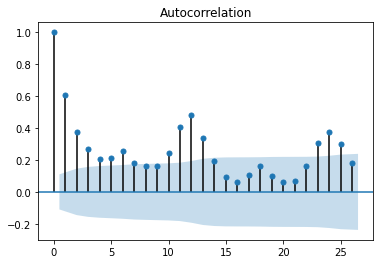

In [14]:
# ACF plot
plot_acf(df_for_arima['TOTAL_CRIMES'].dropna())
plt.show()

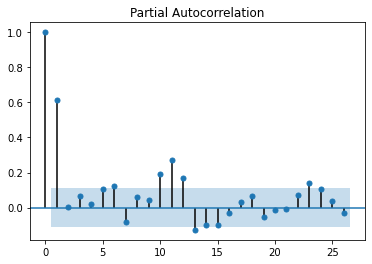

In [15]:
# PACF plot
plot_pacf(df_for_arima['TOTAL_CRIMES'].dropna())
plt.show()

In [16]:
from statsmodels.tsa.stattools import kpss

# Checking stationarity using ADF test
result = adfuller(df_for_arima['TOTAL_CRIMES'])
print(result[1])
result = adfuller(df_for_arima['TOTAL_CRIMES'].diff().dropna())
print(result[1])
result = adfuller(df_for_arima['TOTAL_CRIMES'].diff().diff().dropna())
print(result[1])
result = adfuller(df_for_arima['TOTAL_CRIMES'].diff().diff().diff().dropna())
print(result[1])
result = adfuller(df_for_arima['TOTAL_CRIMES'].diff().diff().diff().diff().dropna())
print(result[1])

0.08408095819112577
1.2335687140311284e-14
1.6013222211022952e-15
4.48374899435715e-22
7.875771488634917e-25


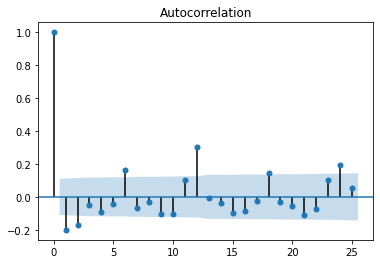

In [17]:
# ACF plot
plot_acf(df_for_arima['TOTAL_CRIMES'].diff().dropna())
plt.show()

Infers that q = 2.

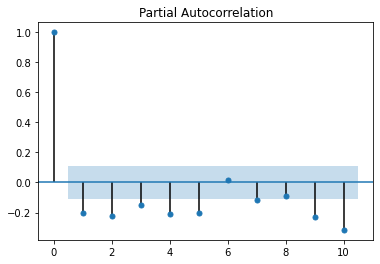

In [18]:
# PACF plot
plot_pacf(df_for_arima['TOTAL_CRIMES'].diff().dropna(), lags=10)
plt.show()

Infers that p=5.

In [19]:
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

# Function for model training and evaluation
# feature_name is the one that contains the count of crimes
def modelTrainEval(df, df_test, feature_name, p, q, d):
  # MODEL TRAINING
  model = ARIMA(df[feature_name].dropna(), order=(p,d,q))
  model = model.fit()
  test_size = len(df_test)
  # MODEL EVALUATION
  predictions = np.array(model.forecast(test_size))
  actual_values = df_test[feature_name]
  df_test["prediction"] = predictions
  df_new_test = pd.concat([df,df_test],join="outer")
  df_new_test = df_new_test.drop(columns = ["MONTH_YEAR", "index"])
  df_new_test.reset_index(drop=True)
  plt.plot(df_new_test["TOTAL_CRIMES"].reset_index(drop=True)[280:],label="Actual values")
  plt.plot(df_new_test["prediction"].reset_index(drop=True),label="Predictions")
  plt.legend()
  plt.title("ARIMA - 6.65%")
  plt.xlabel("Months")
  plt.ylabel("Count")
  plt.show()
  forecast_errors = [np.abs((actual_values[i] - predictions[i])/actual_values[i]) for i in range(test_size)]
  mape = (sum(forecast_errors)/len(forecast_errors))*100
  return mape, predictions, df_new_test

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


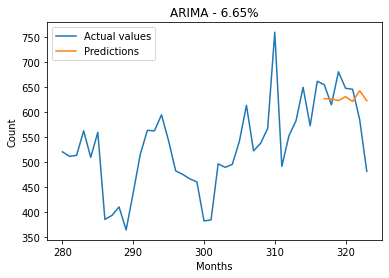

,TOTAL_CRIMES,prediction
0,302,NaN
1,287,NaN
2,287,NaN
3,309,NaN
4,371,NaN
...,...,...
2,680,622.402471
3,647,630.303875
4,645,620.517341
5,584,642.166469


In [31]:
#running the model evaluation and plotting pridictions
#Since we only make pridictions on the test set, we have NaN values in the start. 

#We saw p = 5, Q = 2 using the Plot ACF, but after some tuning and analysis we found P,D, Q = 7,3,1 to give higher accuracy and a more close curve to the actual values

# Passing values of P =5, D = 2, and Q = 2 to ARIMA for a plot
mape, predictions, df_new_test = modelTrainEval(df_for_arima, df_for_arima_test,"TOTAL_CRIMES",5,2,2)
df_new_test

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


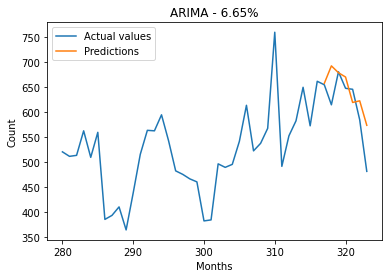

,TOTAL_CRIMES,prediction
0,302,NaN
1,287,NaN
2,287,NaN
3,309,NaN
4,371,NaN
...,...,...
2,680,678.088548
3,647,669.520266
4,645,618.675397
5,584,621.945679


In [20]:
#running the model evaluation and plotting pridictions
#Since we only make pridictions on the test set, we have NaN values in the start. 

#We saw p = 5, Q = 2 using the Plot ACF, but after some tuning and analysis we found P,D, Q = 7,3,1 to give higher accuracy and a more close curve to the actual values

# Passing values of P =7, D = 3, and Q = 1 to ARIMA
mape, predictions, df_new_test = modelTrainEval(df_for_arima, df_for_arima_test,"TOTAL_CRIMES",7,3,1)
df_new_test

#we go ahead with this value

In [21]:
#Printing model accuracy using Mean Average Percentage Error
print("Value for Mape on ARIMA: " , mape)

Value for Mape on ARIMA:  6.65582580496111
